In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil

### Initialise the agent

In [2]:
def policy(q_values, temp=None, policy_type='softmax'):

    '''
    ----
    Agent's policy

    q_values -- q values at the current state
    temp     -- inverse temperature
    type     -- softmax / greeedy
    ----
    '''

    if np.all(q_values == 0):
        return np.array([0.5, 0.5])

    if temp:
        t = temp
    else:
        t = 1
        
    if policy_type == 'softmax':
        return np.exp(q_values*t)/np.sum(np.exp(q_values*t))
    elif policy_type == 'greedy':
        return np.array(q_values >= q_values.max()).astype(int)
    else:
        raise KeyError('Unknown policy type')

In [3]:
from belief_tree import Tree

In [ ]:
M = np.array([
    [29, 1],
    [1, 1]
])

gamma = 0.9
xi    = 0.0

Q = np.array([0.0, 0.0], dtype=np.float32)

tree = Tree(M, Q, 1, 'softmax')

### Full Bayesian updates

In [ ]:
horizon = 2
tree.build_tree(horizon)
tree.full_updates(gamma)

In [ ]:
qval_tree = tree.qval_tree
qval_tree[0][(0, 0, 0)]

### Replay

In [ ]:
horizon = 2
tree.root_q_values = Q
tree.build_tree(horizon)
qval_history, need_history, replays = tree.replay_updates(gamma, xi)

In [ ]:
qval_tree = tree.qval_tree
qval_tree[0][(0, 0, 0)]

### Generate replay tree

In [ ]:
from tex_tree import generate_big_tex_tree

save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/Data/example_tree/seq/'
if os.path.exists(save_folder):
    shutil.rmtree(save_folder)
    os.mkdir(save_folder)
else:
    os.makedirs(save_folder)

for idx, rep in enumerate(replays):
    these_replays = replays[:idx+1]
    save_path = os.path.join(save_folder, 'tex_tree_%u.tex'%idx)
    generate_big_tex_tree(horizon, these_replays, qval_history[idx], need_history[idx], save_path)

### Distribution updates asymmetry 

In [ ]:
from scipy.stats import beta
from scipy.special import kl_div

In [ ]:
x = np.linspace(0.001, 1, 100)

a1b, b1b = np.array([2, 1])
rv1b = beta(a1b, b1b)  

a1a, b1a = np.array([3, 1])
rv1a = beta(a1a, b1a)

a1aa, b1aa = np.array([4, 1])
rv1aa = beta(a1aa, b1aa)

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.plot(x, rv1b.pdf(x))
plt.title(r'$\alpha=2, \beta=1$')

plt.subplot(132)
plt.plot(x, rv1a.pdf(x))
plt.title(r'$\alpha=3, \beta=1$')

print(np.sum(kl_div(rv1b.pdf(x), rv1a.pdf(x))))

plt.subplot(133)
plt.plot(x, rv1aa.pdf(x))
plt.title(r'$\alpha=4, \beta=1$')

print(np.sum(kl_div(rv1a.pdf(x), rv1aa.pdf(x))))

plt.tight_layout()

# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/Data/betas.png')

### Convergence of replay values

In [ ]:
save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/data/convergence/values/root_greedy'

horizons = np.arange(2, 7)

for alpha_0 in range(1, 13):

    vals     = np.zeros((len(horizons), 2))

    M = np.array([
        [alpha_0, 1],
        [1, 1]
    ])

    gamma = 0.9
    xi    = 0.0

    Q = np.array([0.0, 0.0], dtype=np.float32)

    tree = Tree(M, Q, 1, 'softmax')

    for horizon in horizons:
        # build the tree
        tree.build_tree(horizon)
        # do full bayesian updates
        tree.root_q_values = np.array([0.0, 0.0], dtype=np.float32)
        tree.full_updates(gamma)
        qval_tree = tree.qval_tree
        qvals     = qval_tree[0][(0, 0, 0)]
        print('Horizon %u'%horizon)
        print('Full bayesian ', qvals)
        v_full    = np.max(qvals)
        # do replay
        tree.root_q_values = np.array([0.0, 0.0], dtype=np.float32)
        qval_history, need_history, replays = tree.replay_updates(gamma, xi)
        qval_tree = tree.qval_tree
        qvals     = qval_tree[0][(0, 0, 0)]
        print('Replay ', qvals, '\n')
        v_replay  = np.max(qvals)
        # append
        vals[horizon-horizons[0], 0] = v_full
        vals[horizon-horizons[0], 1] = v_replay

    file_name   = '%u.png'%alpha_0

    fig = plt.figure(figsize=(8, 5), dpi=100, constrained_layout=True)

    x   = np.arange(horizons[0], horizons[-1]+1)
    plt.scatter(x, vals[:, 0], label='Bayes-optimal')
    plt.scatter(x, vals[:, 1], label='Replay with ' + r'$\xi = %.2f$'%xi)
    plt.title(r'$\alpha_0=%u , \beta_0=%u, \alpha_1=%u, \beta_1=%u$'%(M[0, 0], M[0, 1], M[1, 0], M[1, 1]), fontsize=14)
    plt.xlabel('Horizon', fontsize=13)
    plt.ylabel('Root value', fontsize=13)
    plt.legend(prop={'size':13})

    plt.savefig(os.path.join(save_folder, file_name))


In [ ]:
import matplotlib.image as mpimg

plt.figure(figsize=(18, 15), constrained_layout=True, dpi=100)
for i in range(1, 13):
    plt.subplot(4, 3, i)
    plt.imshow(mpimg.imread(os.path.join(save_folder, '%u.png'%i)))
    plt.axis('off')

plt.savefig(os.path.join(save_folder, 'all.png'))

### Number of replays until convergence

In [6]:
save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/data/convergence/num_replays'

# vary these parameters
alphas_0 = np.arange(1, 30)
betas_0  = np.arange(1, 30)

# constant parameters
alpha_1 = 1
beta_1  = 1

gamma = 0.9
xi    = 0.0

for horizon in [5]:

    R = np.full((len(alphas_0), len(betas_0)), np.nan)

    for alpha_0 in alphas_0:
        for beta_0 in betas_0:
            
            num_replays = 0

            # prior belie at the root
            M = np.array([
                [alpha_0, beta_0],
                [alpha_1, beta_1],
            ], dtype=int)

            # MF Q values at the root
            Q    = np.array([0.0, 0.0], dtype=np.float32)

            # initialise the agent
            tree = Tree(M, Q, 1, 'softmax')

            # build the tree
            tree.build_tree(horizon)
            
            # do full bayesian updates
            tree.root_q_values = np.array([0.0, 0.0], dtype=np.float32)
            tree.full_updates(gamma)
            qval_tree = tree.qval_tree
            qvals     = qval_tree[0][(0, 0, 0)]
            print(r'$\alpha_0=%u, \beta_0=%u$'%(alpha_0, beta_0))
            # v_full    = np.round(np.max(qvals), 3)
            v_full = np.max(qvals)
            
            # do replay
            tree.root_q_values = np.array([0.0, 0.0], dtype=np.float32)
            qval_history, need_history, replays = tree.replay_updates(gamma, xi)
            for qval_tree_idx in range(len(qval_history)):
                qval_tree = qval_history[qval_tree_idx]
                qvals     = qval_tree[0][(0, 0, 0)]
                # v_replay  = np.round(np.max(qvals), 3)
                v_replay  = np.max(qvals)
                if v_replay == v_full: # converged after this many replays
                    R[alpha_0-alphas_0[0], beta_0-betas_0[0]] = qval_tree_idx
                    break
    
    fig = plt.figure(figsize=(10, 8), dpi=100, constrained_layout=True)
    # plt.contourf(R, vmin=0, vmax=np.nanmax(R))
    plt.pcolormesh(R, vmin=0, vmax=np.nanmax(R))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Number of replays', rotation=270, fontsize=14, labelpad=18)
    plt.xlabel(r'$\beta_0$', fontsize=14)
    plt.xticks(range(R.shape[0]), range(1, R.shape[0]+1))
    plt.ylabel(r'$\alpha_0$', fontsize=14)
    plt.yticks(range(R.shape[1]), range(1, R.shape[1]+1))
    plt.title(r'$\alpha_1=%u, \beta_1=%u$'%(alpha_1, beta_1), fontsize=18)

    file_name = 'horizon%u_alpha%u_beta%u'%(horizon, alpha_1, beta_1)
    np.save(os.path.join(save_folder, 'data', file_name + '.npy'), R)
    plt.savefig(os.path.join(save_folder, file_name + '.png'))

    plt.close()

    print('Done with horizon %u'%horizon)

$\alpha_0=1, \beta_0=1$
$\alpha_0=1, \beta_0=2$
$\alpha_0=1, \beta_0=3$
$\alpha_0=1, \beta_0=4$
$\alpha_0=1, \beta_0=5$
$\alpha_0=1, \beta_0=6$
$\alpha_0=1, \beta_0=7$
$\alpha_0=1, \beta_0=8$
$\alpha_0=1, \beta_0=9$
$\alpha_0=1, \beta_0=10$
$\alpha_0=1, \beta_0=11$
$\alpha_0=1, \beta_0=12$
$\alpha_0=1, \beta_0=13$
$\alpha_0=1, \beta_0=14$
$\alpha_0=1, \beta_0=15$
$\alpha_0=1, \beta_0=16$
$\alpha_0=1, \beta_0=17$
$\alpha_0=1, \beta_0=18$
$\alpha_0=1, \beta_0=19$
$\alpha_0=1, \beta_0=20$
$\alpha_0=1, \beta_0=21$
$\alpha_0=1, \beta_0=22$
$\alpha_0=1, \beta_0=23$
$\alpha_0=1, \beta_0=24$
$\alpha_0=1, \beta_0=25$
$\alpha_0=1, \beta_0=26$
$\alpha_0=1, \beta_0=27$
$\alpha_0=1, \beta_0=28$
$\alpha_0=1, \beta_0=29$
$\alpha_0=2, \beta_0=1$
$\alpha_0=2, \beta_0=2$
$\alpha_0=2, \beta_0=3$
$\alpha_0=2, \beta_0=4$
$\alpha_0=2, \beta_0=5$
$\alpha_0=2, \beta_0=6$
$\alpha_0=2, \beta_0=7$
$\alpha_0=2, \beta_0=8$
$\alpha_0=2, \beta_0=9$
$\alpha_0=2, \beta_0=10$
$\alpha_0=2, \beta_0=11$
$\alpha_0=2, \beta

KeyboardInterrupt: 

### Replay threshold and value convergence

$\alpha_0=5, \beta_0=1$
$\alpha_0=5, \beta_0=1$
$\alpha_0=5, \beta_0=1$
$\alpha_0=5, \beta_0=1$
$\alpha_0=5, \beta_0=1$


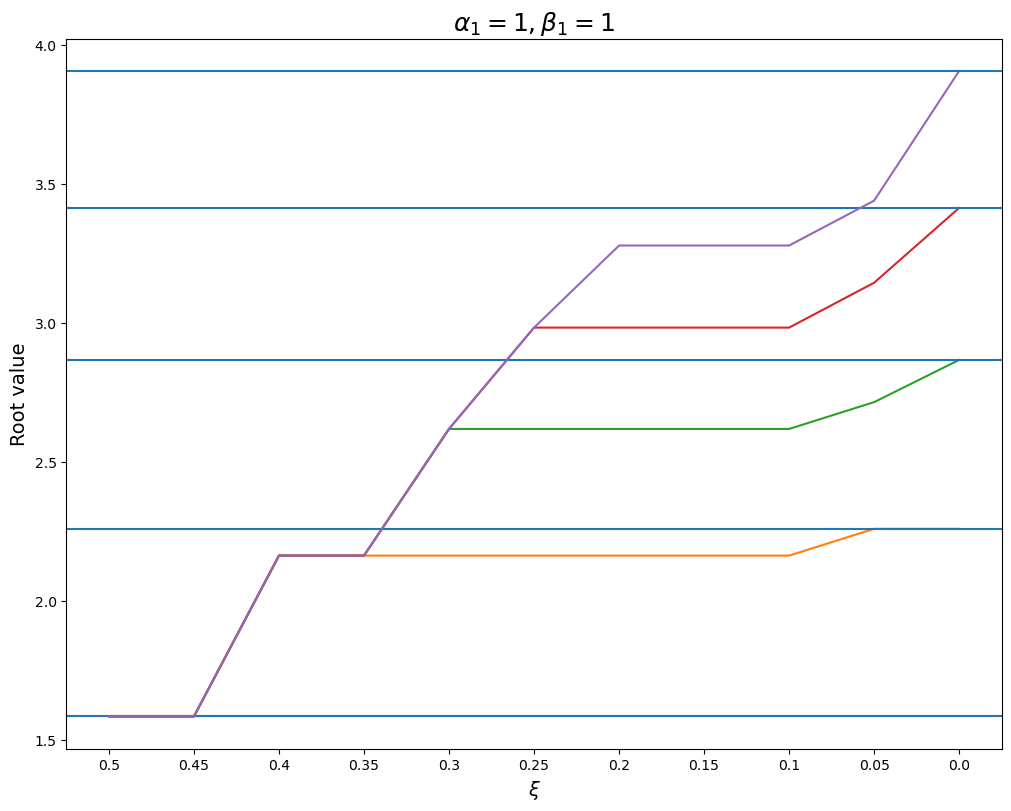

In [17]:
save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/data/convergence/xi'

# vary these parameters
xis       = np.linspace(0, 0.5, 11)
horizons  = [2, 3, 4, 5, 6]

# constant parameters
alpha_0 = 5
beta_0  = 1
alpha_1 = 1
beta_1  = 1

gamma   = 0.9

# prior belie at the root
M = np.array([
    [alpha_0, beta_0],
    [alpha_1, beta_1],
], dtype=int)

# MF Q values at the root
Q    = np.array([0.0, 0.0], dtype=np.float32)

# initialise the agent
tree = Tree(M, Q, 1, 'softmax')

# store results here
R    = np.zeros((len(horizons), len(xis)))
R_true = np.zeros(len(horizons))

for hidx, horizon in enumerate(horizons):
            
    num_replays = 0

    # build the tree
    tree.build_tree(horizon)
    
    # do full bayesian updates
    tree.root_q_values = np.array([0.0, 0.0], dtype=np.float32)
    tree.full_updates(gamma)
    qval_tree = tree.qval_tree
    qvals     = qval_tree[0][(0, 0, 0)]
    print(r'$\alpha_0=%u, \beta_0=%u$'%(alpha_0, beta_0))
    # v_full    = np.round(np.max(qvals), 3)
    v_full = np.max(qvals)
    R_true[hidx] = v_full
    
    for xidx, xi in enumerate(xis):

        # do replay
        tree.root_q_values = np.array([0.0, 0.0], dtype=np.float32)
        qval_history, need_history, replays = tree.replay_updates(gamma, xi)
        qval_tree = tree.qval_tree
        qvals     = qval_tree[0][(0, 0, 0)]
        v_replay  = np.max(qvals)
        R[hidx, xidx] = v_replay
    
fig = plt.figure(figsize=(10, 8), dpi=100, constrained_layout=True)
for hi in range(len(horizons)):
    plt.plot(R[hi, ::-1], label='Horizon %u'%(hi+2))
    plt.axhline(R_true[hi])

plt.xlabel(r'$\xi$', fontsize=14)
plt.xticks(range(R.shape[1]), np.round(xis[::-1], 2))
plt.ylabel('Root value', fontsize=14)
plt.title(r'$\alpha_1=%u, \beta_1=%u$'%(alpha_1, beta_1), fontsize=18)

file_name = 'alpha0%u_beta0%u_alpha1%u_beta1%u'%(alpha_0, beta_0, alpha_1, beta_1)
np.save(os.path.join(save_folder, 'data', file_name + '.npy'), R)
plt.savefig(os.path.join(save_folder, file_name + '.png'))

# plt.close()